In [3]:
import numpy as np
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')
import matplotlib.pyplot as plt

# Example of creating an R file with a flag for tolerance parameters and scale parameters
### This specific example contains JWST NIRSpec and MIRI data

### for further details, read: https://ui.adsabs.harvard.edu/abs/2023ApJ...951L..48B/abstract

In [45]:
obs_data = np.loadtxt('/Users/viki/Desktop/Brewster/brewster_v2/Sinking_Silicates/New_Reductions/GJ499C/GJ499C_spectrum.txt')
print(np.shape(obs_data))

(521, 3)


[[ 1.01236069  0.01466787]
 [ 1.02702856  0.01483363]
 [ 1.04202795  0.01516396]
 ...
 [11.94931889  0.01779175]
 [11.9670887   0.01774836]
 [11.9848156   0.0177269 ]]


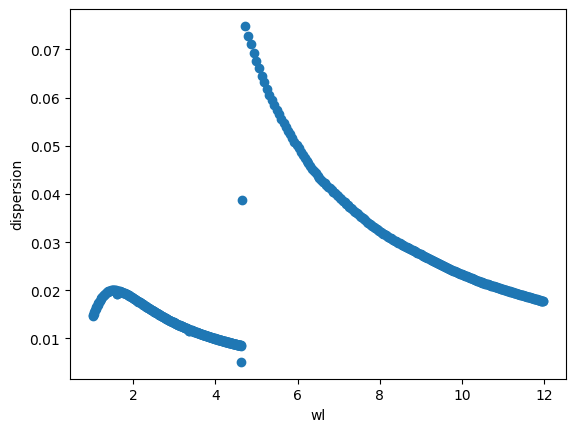

In [53]:
obs_data = np.loadtxt('/Users/viki/Desktop/Brewster/brewster_v2/Sinking_Silicates/New_Reductions/GJ499C/GJ499C_spectrum.txt')

#obs_data = np.loadtxt('/Users/viki/Desktop/Brewster/brewster_v2/G570D_2MassJcalib.dat')

wl =  obs_data[:, 0]  #lambda in microns


d_wl = np.zeros_like(wl)   #pixel width, dispersion
d_wl[1:-1] = (wl[2:] - wl[:-2]) / 2
d_wl[0] = wl[1] - wl[0]
d_wl[-1] = wl[-1] - wl[-2]

print(np.array([wl, d_wl]).T)



##### Slit limited parameters

slit_limited = 1.0  #1.0 yes, 0.0 no

resel_slit_lim = 2.2 # resolution element in case of slit limited, i.e. number of pixels per resolution



##### Source limited parameters

source_limited = 1.0 #1.0 yes, 0.0 no

D = 6.5e+6  #mirror size in micrometers

theta_pix = 0.11 #angular size of pixel



##### Both nirspec miri


nirspec_wl_range = [0.0, 4.634954929351806641e+0]  #the wavelength range of the nirspec data in micron

miri_wl_range = [4.636688709259033203e+00, 12.0] 

plt.scatter(wl,d_wl)
plt.ylabel('dispersion')
plt.xlabel('wl')

####### scale factor parameters


scale = 0.0  #if there are no scale factors, set it to 0.0, else set it to something else

#scale_none = [np.min(obs_data[:, 0]) , np.max(obs_data[:, 0])] #wavelength range of the whole data if there's no scaleparameter
#scale_1 = [0.0, 4.63250113]
#scale_2 = [4.63684082, 12.0]

#plt.xlim(1,4.5)
#plt.ylim(0,0.025)

In [61]:
def instrument_R(wl):
    
    '''Function that provides the Resolving Power (R) as a function of wavelength (wl) in micron 
       with flags for the tolerance param and scale param,
       depending on jwst instrument'''
    
    if slit_limited == 1.0 and source_limited == 0.0:
        
        R = wl/(d_wl * resel_slit_lim)
        
        log_f_param = np.ones_like(R)

        scale_param = np.zeros_like(R)
        
        return R, wl, log_f_param, scale_param
    
    
    elif source_limited == 1.0 and slit_limited == 0.0:
        
        theta_lambda = (648000/np.pi) * 1.028 * (wl/D) #FWHM in arcsec
        
        
        R = wl / (d_wl * (theta_lambda / theta_pix))
        
        log_f_param = np.ones_like(R)

        scale_param = np.zeros_like(R)
        
        return R, wl, log_f_param, scale_param
    
    
    elif source_limited == 1.0 and slit_limited == 1.0:
        
        ### nirspec
        
        nirspec_wl = wl[(wl >= nirspec_wl_range[0]) & (wl <= nirspec_wl_range[1])]
        
        nirspec_d_wl = d_wl[(wl >= nirspec_wl_range[0]) & (wl <= nirspec_wl_range[1])] 
        
        R_nirspec = nirspec_wl/(nirspec_d_wl * resel_slit_lim)

        theta_lambda_nirspec = (648000/np.pi) * 1.028 * (nirspec_wl/D)
        #print('theta_lambda_nirspec', theta_lambda_nirspec)
        
        log_f_param_nirspec = np.ones_like(R_nirspec)

        scale_param_nirspec = np.zeros_like(R_nirspec)

        
        
        ### miri
        
        miri_wl = wl[(wl >= miri_wl_range[0]) & (wl <= miri_wl_range[1])]
        
        miri_d_wl = d_wl[(wl >= miri_wl_range[0]) & (wl <= miri_wl_range[1])]
        
        theta_lambda = (648000/np.pi) * 1.028 * (miri_wl/D)
        #print('theta_lambda_miri', theta_lambda)
        
        R_miri = miri_wl / (miri_d_wl * (theta_lambda / theta_pix))
        #print(np.shape(R_miri),np.shape(R_nirspec))
        
        log_f_param_miri = np.full_like(R_miri, 2)

        if scale == 0.0:
            scale_param_miri = np.zeros_like(R_miri)
        else:
            scale_param_miri = np.ones_like(R_miri)

        
        #plt.plot(nirspec_wl,R_nirspec)
        #plt.plot(miri_wl,R_miri)
        
        return np.concatenate((R_nirspec, R_miri)), np.concatenate((nirspec_wl, miri_wl)), np.concatenate((log_f_param_nirspec, log_f_param_miri)), np.concatenate((scale_param_nirspec, scale_param_miri))
    
    else:
        
        print('Error: incorrect values given for source_limited and slit_limited.')
        
           
        

In [55]:
R, wavelengths, log_f, scale = instrument_R(wl)
print(np.shape(R))
print(np.shape(wavelengths))
print(np.shape(log_f))
print(np.shape(scale))
#print(np.array([R, wavelengths,log_f, scale]).T)
print(np.column_stack((R, wavelengths, log_f, scale)))
print(np.mean(R))
print(np.max(R))
#np.savetxt('SDSS_R.txt',np.array([R, wavelengths]).T )
np.savetxt('GJ499C_R_file.txt',np.array([R, wavelengths,log_f, scale]).T )

(521,)
(521,)
(521,)
(521,)
[[ 31.37224385   1.01236069   1.           0.        ]
 [ 31.47113628   1.02702856   1.           0.        ]
 [ 31.23518715   1.04202795   1.           0.        ]
 ...
 [189.52616468  11.94931889   2.           0.        ]
 [189.98952894  11.9670887    2.           0.        ]
 [190.21950335  11.9848156    2.           0.        ]]
126.55136955726232
410.6012731750383


In [56]:
print(np.shape([R, wavelengths,log_f, scale]))

(4, 521)


In [57]:
print(np.shape(wl),np.shape(R))

(521,) (521,)


Text(0, 0.5, 'Resolving Power')

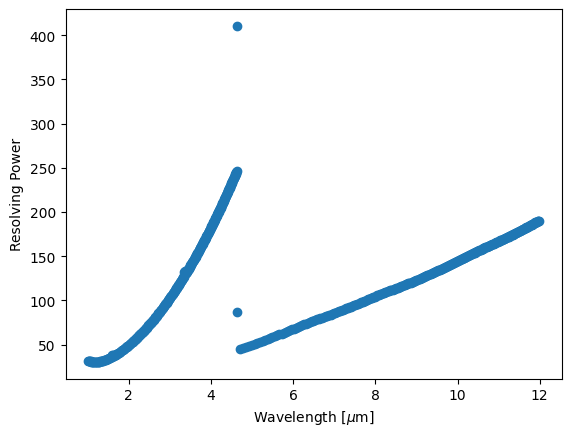

In [58]:
plt.scatter(wl, R)
plt.xlabel(f"Wavelength [$\mu$m]")
plt.ylabel('Resolving Power')

126.08064294736934 127.22366610392096 246.34931597282173 30.323947818864518


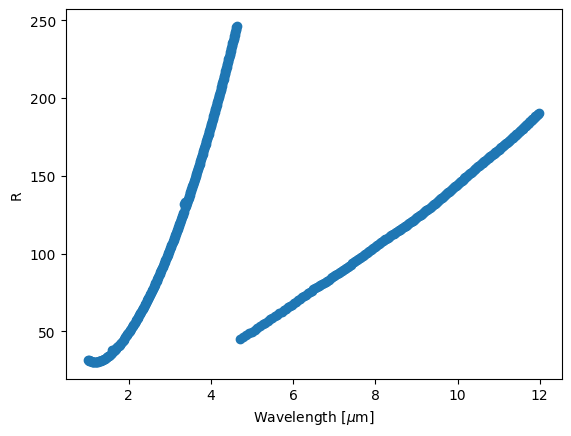

In [59]:
mask = (wl < 4.63) | (wl > 4.64)
wl_masked = wl[mask]
R_masked = R[mask]
plt.xlabel(f"Wavelength [$\mu$m]")
plt.ylabel("R")
plt.scatter(wl_masked, R_masked)
print(np.mean(R_masked), np.median(R_masked), np.max(R_masked), np.min(R_masked))
#plt.xlim(5,10)
#plt.yscale('log')
#plt.ylim(10,10000)